### Using this Jupyter Notebook with a local virtualenv (Mac/BSD)

First, clone the repo from GitHub - then, within the project dir:

**Create a virtual env**
1. `python3 -m venv venv` # creates a virtualenv named vend at ./venv
1. `source venv/bin/activate` # activate the venv
1. `type python` # Confirm this points to your venv interpreter, see below
```
(venv) stu@bast osic_kaggle % type python
python is /Users/stu/dev/osic_kaggle/venv/bin/python
```

**Install the runtime**

1. `pip3 install pip --upgrade` # upgrade pip
1. `pip3 install -r requirements.txt` # install dependencies
1. `python3 -m ipykernel install --user --name=osic-kaggle` # create an ipython kernel for the venv

With the virtual env enabled:

1. `jupyter notebook OSIC\ EDA.ipynb` # Start the notebook
1. Within the notebook, select the Kernel options bar > "Change Kernel" > select "osic-kaggle"

Congrats, the notebook should work properly in a virtualenv!

**Deactivate**

At any time, type `deactivate` in your shell to leave the virtualenv scope



### Runtime-dependent Data Imports
In the cell below, uncomment the section corresponding to the runtime you are using.
**Leave all other sections commented!**


In [43]:
# Colab + Google Drive
"""
# Mount Google Drive and authn to it
import glob
from google.colab import drive 

# This is execution-blocking & requires user authentication : Follow the steps as guided 
drive.mount('/content/drive')

DATA_DIR = "/content/drive/My Drive/osic_kaggle/data/"
"""

# Local - adjust to your filesystem as needed
DATA_DIR = "../tmp/osic-pulmonary-fibrosis-progression/" # Local

# Shared/Subdirs - you probably don't need to change this
# Quick hackiness instead of using the Path lib
TRAINING_DIR = f"{DATA_DIR}train" if DATA_DIR[-1] == "/" else f"{DATA_DIR}/train"
TESTING_DIR = f"{DATA_DIR}test" if DATA_DIR[-1] == "/" else f"{DATA_DIR}/test"


### Runtime-dependent lib installation
If running in a local / virtualenv, you should use `pip3 install -r requirements.txt` to install dependencies.

If running in Google Colab, uncomment the below cell to install dependencies

In [41]:
# !pip install numpy pandas seaborn pydicom matplotlib tqdm

In [44]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import pydicom
from pathlib import Path
import matplotlib.pyplot as plt
import tqdm

In [45]:
sns.set_style('whitegrid')


# Tabular Data
**clinical patient info and FVC**
- Patient (str): a unique Id for each patient (also the name of the patient's DICOM folder)
- Weeks (int): the relative number of weeks pre/post the baseline CT (may be negative)
- FVC (int): the recorded lung capacity in ml
- Percent (float): a computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics
- Age (int)
- Sex (str)
- SmokingStatus (str)

In [46]:
# use the previously set DATA_DIR
train_df = pd.read_csv(DATA_DIR + 'train.csv')
test_df = pd.read_csv(DATA_DIR + 'test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(1549, 7)
(5, 7)


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [13]:
print(f"Found {train_df['Patient'].nunique()} unique patients")

Found 176 unique patients


### Distribution of FVC measurements

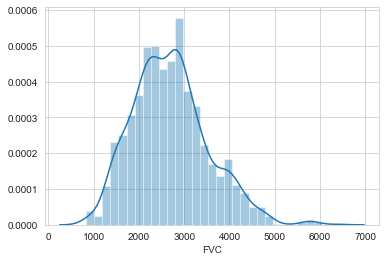

In [14]:
sns.scatterplot(data = train_df, x='Age', y='FVC', hue = 'Sex', alpha=.5);

C:\ProgramData\Anaconda3\envs\OSIC_EDA\lib\site-packages\seaborn\axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


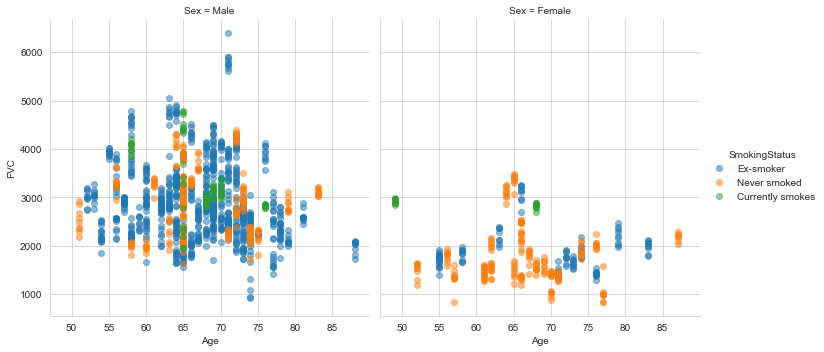

In [6]:
g = sns.FacetGrid(data = train_df, col='Sex', hue='SmokingStatus', size=5, aspect=1);
g = (g.map(plt.scatter, 'Age', 'FVC' ,alpha=.5).add_legend())

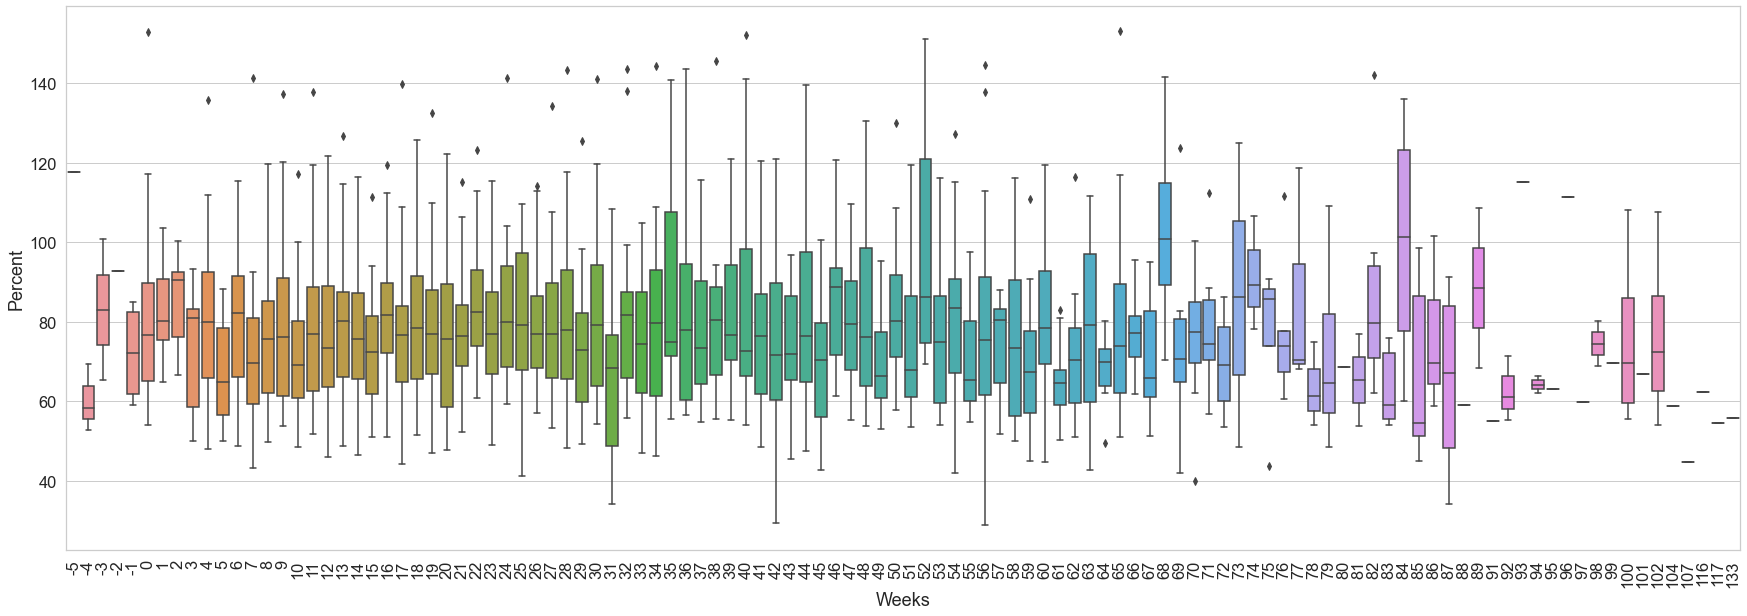

In [15]:
with sns.plotting_context("notebook",font_scale=1.5):
    fig, ax = plt.subplots(figsize=(30, 10))
    sns.boxplot(data=train_df, x='Weeks', y='Percent', ax=ax);
    plt.xticks(rotation=90);

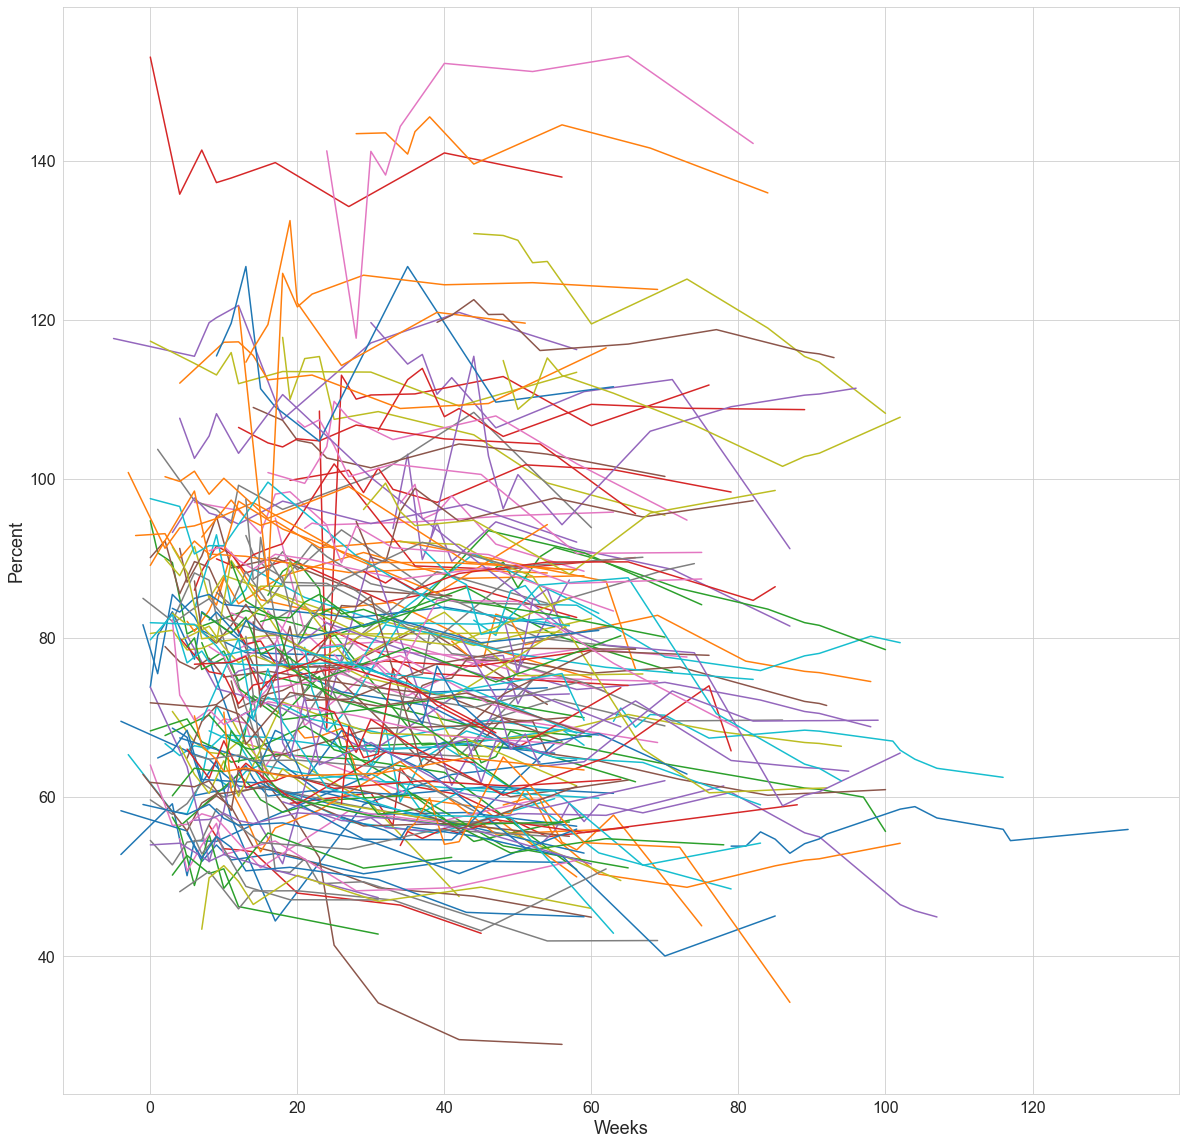

In [13]:
fig, ax = plt.subplots(figsize=(20,20))
train_df.groupby(['Weeks','Patient'])['Percent']\
    .median()\
    .unstack()\
    .interpolate(method='linear', limit_area='inside')\
    .plot(ax=ax,legend=None);
plt.ylabel('Percent', fontsize=18);
plt.yticks(fontsize=16);
plt.xlabel('Weeks', fontsize=18);
plt.xticks(fontsize=16);

### Distribution of Age

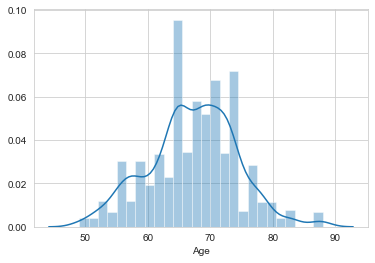

In [14]:
sns.distplot(train_df['Age']);

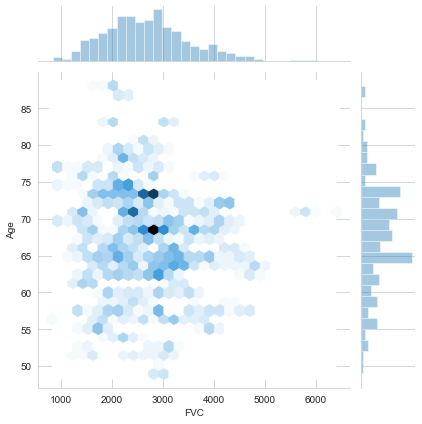

In [16]:
sns.jointplot(x="FVC", y="Age", data=train_df, kind="hex");

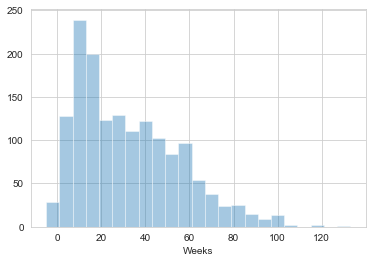

In [17]:
sns.distplot(train_df['Weeks'], kde=False);

## DICOM Data

In [47]:
# Use the previously set training dir
train_dcms =  [path for path in Path(TRAINING_DIR).rglob('*.dcm')]
train_folders = os.listdir(TRAINING_DIR)
print(f'training set has {len(train_dcms)} total images, comprising {len(train_folders)} patients')

training set has 33026 total images, comprising 176 patients


In [48]:
# read a single DICOM header. OF NOTE:
# (0020, 0032) Image Position (Patient)     DS: [-158.700, -153.500, -69.750] --- x,y,z of image w.r.t. patient
# (0028, 0004) Photometric Interpretation   CS: 'MONOCHROME2' --- dark vs light value
# (0028, 1050) Window Center                DS: "-500.0" --- brightness
# (0028, 1051) Window Width                 DS: "-1500.0" --- contrast
# (7fe0, 0010) Pixel Data                   OW: Array of 524288 elements --- pixel data as byte array
print(train_dcms[0])
dimg = pydicom.dcmread(train_dcms[0])
dimg

../tmp/osic-pulmonary-fibrosis-progression/train/ID00296637202279895784347/16.dcm


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.12779743606216391659179055517331126608
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'HELIX']
(0008, 0018) SOP Instance UID                    UI: 2.25.12779743606216391659179055517331126608
(0008, 0060) Modality                            CS: 'CT'
(000

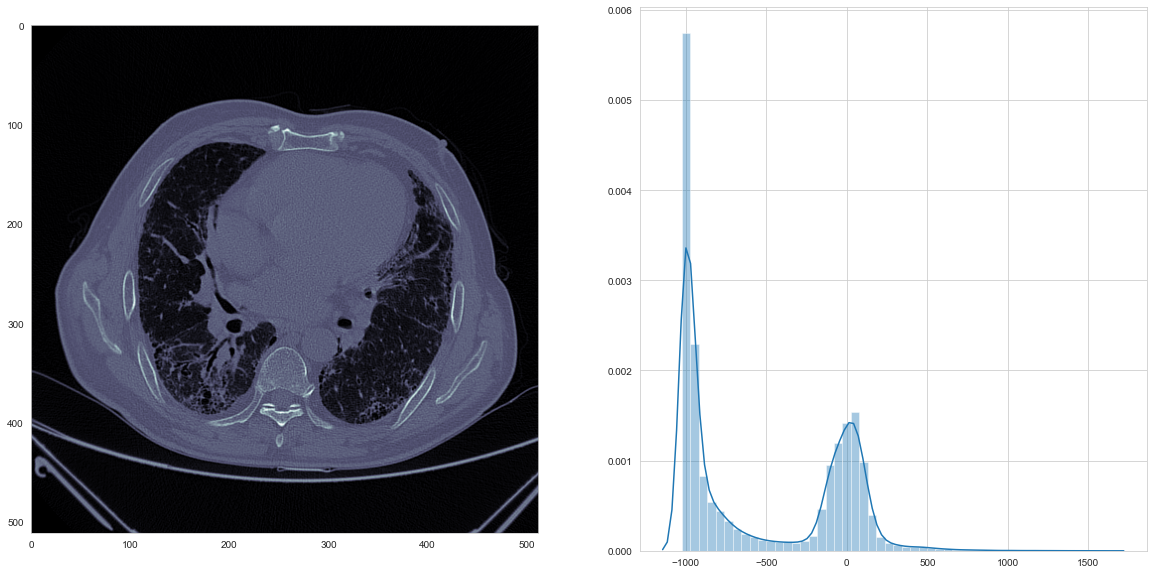

In [20]:
# plot a single image
# low values appear as dark, high values as light (MONOCHROME2)
fig, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].imshow(dimg.pixel_array, cmap=plt.cm.bone)
axes[0].grid(False);
sns.distplot(dimg.pixel_array.flatten(), ax=axes[1]);

In [21]:
# Function to rescale pixels to common Hounsfield Units scale (https://en.wikipedia.org/wiki/Hounsfield_scale)
# Air: -1000
# Water: 0
# Bone: 300-3000
# Metal: 2000
def hu_scaled_px(dicom_image):
    # rescales per rescale slope and intercept
    img = dicom_image.pixel_array
    return img if dicom_image.Modality == "CR" else img * dicom_image.RescaleSlope + dicom_image.RescaleIntercept
hu_scaled_px(dimg)

array([[-1024., -1024., -1024., ..., -1024., -1024., -1024.],
       [-1024., -1024., -1024., ..., -1024.,  -919., -1024.],
       [-1024., -1024., -1024., ..., -1000.,  -982.,  -999.],
       ...,
       [-1024., -1024., -1024., ..., -1009.,  -974.,  -995.],
       [-1024., -1024., -1024., ..., -1014.,  -994., -1024.],
       [-1024., -1024., -1024., ..., -1024., -1024., -1024.]])

In [22]:
def extract_dicom_meta_data(filename: str) -> dict:
    # Load image
    
    image_data = pydicom.read_file(filename)
    img=np.array(image_data.pixel_array).flatten()
    row = {
        'Patient': image_data.PatientID,
        'body_part_examined': image_data.BodyPartExamined,
        'image_position_patient': image_data.ImagePositionPatient,
        'image_orientation_patient': image_data.ImageOrientationPatient,
        'photometric_interpretation': image_data.PhotometricInterpretation,
        'rows': image_data.Rows,
        'columns': image_data.Columns,
        'pixel_spacing': image_data.PixelSpacing,
        'window_center': image_data.WindowCenter,
        'window_width': image_data.WindowWidth,
        'modality': image_data.Modality,
        'StudyInstanceUID': image_data.StudyInstanceUID,
        'SeriesInstanceUID': image_data.StudyInstanceUID,
        'StudyID': image_data.StudyInstanceUID, 
        'SamplesPerPixel': image_data.SamplesPerPixel,
        'BitsAllocated': image_data.BitsAllocated,
        'BitsStored': image_data.BitsStored,
        'HighBit': image_data.HighBit,
        'PixelRepresentation': image_data.PixelRepresentation,
        'RescaleIntercept': image_data.RescaleIntercept,
        'RescaleSlope': image_data.RescaleSlope,
        'img_min': np.min(img),
        'img_max': np.max(img),
        'img_mean': np.mean(img),
        'img_std': np.std(img)}

    return row

In [23]:
meta_data_df = []
error_log = []
for filename in tqdm.tqdm(train_dcms):
    try:
        meta_data_df.append(extract_dicom_meta_data(filename))
    except Exception as e:
        error_log.append((filename, e))
        continue
        
# Convert to a pd.DataFrame from dict
meta_data_df = pd.DataFrame.from_dict(meta_data_df)
meta_data_df.to_csv('meta_data_df.csv', index=False)
meta_data_df.head()

100%|██████████| 33026/33026 [02:40<00:00, 205.29it/s]


,Patient,body_part_examined,image_position_patient,image_orientation_patient,photometric_interpretation,rows,columns,pixel_spacing,window_center,window_width,...,BitsAllocated,BitsStored,HighBit,PixelRepresentation,RescaleIntercept,RescaleSlope,img_min,img_max,img_mean,img_std
0,ID00296637202279895784347,Chest,"[-198, -35, -491.099976]","[1, 0, 0, 0, 1, 0]",MONOCHROME2,512,512,"[0.714844, 0.714844]",-500.0,-1500.0,...,16,16,15,1,0.0,1.0,-1024,1600,-532.366531,484.292470
1,ID00296637202279895784347,Chest,"[-198, -35, -501.099976]","[1, 0, 0, 0, 1, 0]",MONOCHROME2,512,512,"[0.714844, 0.714844]",-500.0,-1500.0,...,16,16,15,1,0.0,1.0,-1024,1635,-534.258228,489.548827
2,ID00296637202279895784347,Chest,"[-198, -35, -481.099976]","[1, 0, 0, 0, 1, 0]",MONOCHROME2,512,512,"[0.714844, 0.714844]",-500.0,-1500.0,...,16,16,15,1,0.0,1.0,-1024,1646,-530.787209,487.742244
3,ID00296637202279895784347,Chest,"[-198, -35, -621.099976]","[1, 0, 0, 0, 1, 0]",MONOCHROME2,512,512,"[0.714844, 0.714844]",-500.0,-1500.0,...,16,16,15,1,0.0,1.0,-1024,1583,-478.588120,499.389977
4,ID00296637202279895784347,Chest,"[-198, -35, -611.099976]","[1, 0, 0, 0, 1, 0]",MONOCHROME2,512,512,"[0.714844, 0.714844]",-500.0,-1500.0,...,16,16,15,1,0.0,1.0,-1024,1553,-468.104801,501.146437


In [24]:
len(error_log)

488

In [25]:
# examine dataframe
meta_data_df.columns

Index(['Patient', 'body_part_examined', 'image_position_patient',
       'image_orientation_patient', 'photometric_interpretation', 'rows',
       'columns', 'pixel_spacing', 'window_center', 'window_width', 'modality',
       'StudyInstanceUID', 'SeriesInstanceUID', 'StudyID', 'SamplesPerPixel',
       'BitsAllocated', 'BitsStored', 'HighBit', 'PixelRepresentation',
       'RescaleIntercept', 'RescaleSlope', 'img_min', 'img_max', 'img_mean',
       'img_std'],
      dtype='object')

In [26]:
meta_data_df['Patient'].nunique()

173

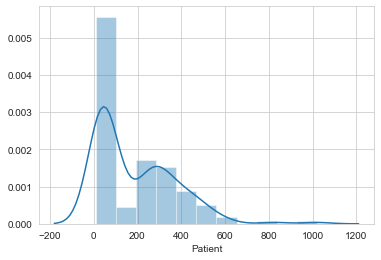

In [27]:
sns.distplot(meta_data_df['Patient'].value_counts());

In [28]:
meta_data_df['image_orientation_patient'].apply(lambda x: [int(a) for a in x]).value_counts()

[1, 0, 0, 0, 1, 0]      31758
[-1, 0, 0, 0, -1, 0]      627
[1, 0, 0, 0, -1, 0]        62
[0, 0, 0, 0, 1, 0]         53
[-1, 0, 0, 0, 1, 0]        38
Name: image_orientation_patient, dtype: int64

In [29]:
meta_data_df['photometric_interpretation'].value_counts()

MONOCHROME2    32538
Name: photometric_interpretation, dtype: int64

In [30]:
meta_data_df.groupby(['window_center','window_width']).size()

window_center  window_width
-1565.0         1383.0           238
-500.0         -1500.0         30424
                1400.0          1247
                1500.0           629
dtype: int64

In [31]:
meta_data_df[]
sns.scatterplot(data = meta_data_df, x='img_max', y='img_min', hue='img_mean');

SyntaxError: invalid syntax (<ipython-input-31-a4e6e501a3bc>, line 1)

In [ ]:
# TODO: create formal training-testing dataframe with uniform orientation + window center/width
# 

In [42]:
#Plot 3 comparisons
def plot_comparison3(df, feature, feature1, feature2):
    "Plot 3 comparisons from a dataframe"
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25, 4))
    s1 = sns.countplot(df[feature], ax=ax1)
    s1.set_title(feature)
    s2 = sns.countplot(df[feature1], ax=ax2)
    s2.set_title(feature1)
    s3 = sns.countplot(df[feature2], ax=ax3)
    s3.set_title(feature2)
    plt.show()

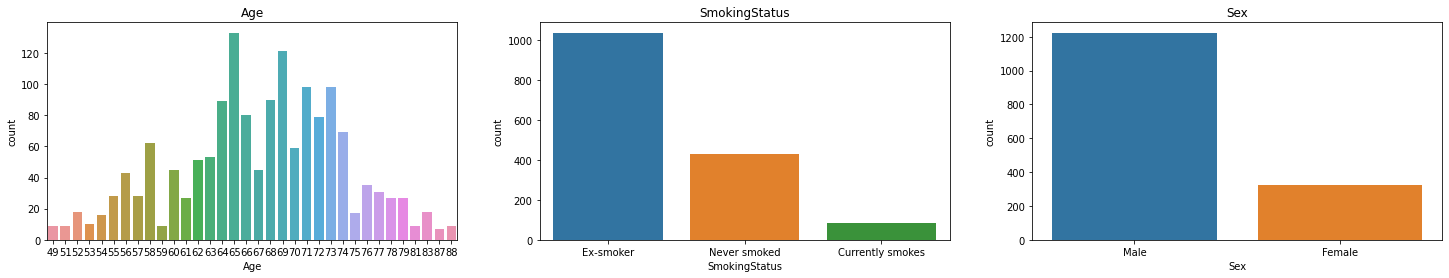

In [44]:
plot_comparison3(train_df, "Age", "SmokingStatus", "Sex")

In [46]:
patient_01 = train_df[train_df.Patient == 'ID00007637202177411956430']
patient_01

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
5,ID00007637202177411956430,17,2101,52.868646,79,Male,Ex-smoker
6,ID00007637202177411956430,29,2000,50.327126,79,Male,Ex-smoker
7,ID00007637202177411956430,41,2064,51.937594,79,Male,Ex-smoker
8,ID00007637202177411956430,57,2057,51.761449,79,Male,Ex-smoker


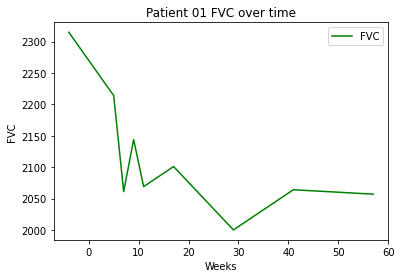

In [53]:
patient_01.plot(kind='line',x='Weeks',y='FVC',color='green')
plt.ylabel("FVC")
plt.title("Patient 01 FVC over time")
plt.show()

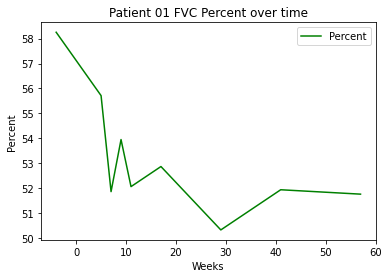

In [54]:
patient_01.plot(kind='line',x='Weeks',y='Percent',color='green')
plt.ylabel("Percent")
plt.title("Patient 01 FVC Percent over time")
plt.show()